In [2]:
from src.inference.predict import ModelPredictor
from src.features.feature_pipeline import FeatureEngineer
import pandas as pd
feature_engineer = FeatureEngineer()
model_predictor = ModelPredictor(feature_engineer=feature_engineer)

# Invalid test data (missing fields)
new_data = {
    "invalid_field": ["123"]
}
new_data_df = pd.DataFrame(new_data)

model_predictor.predict(new_data_df)

metadata: {'model_name': 'ambitious-trout-584', 'run_id': '9172fc874bfd473e9908e6d19d3052ee', 'test_mean_absolute_error': 3.9370544090572275}
model_uri: runs:/9172fc874bfd473e9908e6d19d3052ee/model


INFO:alembic.runtime.migration:Context impl SQLiteImpl.
INFO:alembic.runtime.migration:Will assume non-transactional DDL.
INFO:src.features.feature_pipeline:Transforming new data for inference...
INFO:src.features.feature_pipeline:DictVectorizer loaded from src/artifacts/dict_vectorizer.pkl


KeyError: 'PULocationID'

In [1]:
from src.utils.print_directory import print_dir_structure

print_dir_structure(".")

├── .gitignore
├── .python-version
├── Dockerfile
├── LICENSE
├── mlflow.db
├── pyproject.toml
├── README.md
├── src
│   ├── .env
│   ├── .env.example
│   ├── __init__.py
│   ├── app.py
│   ├── artifacts
│   │   ├── __init__.py
│   │   ├── best_model.json
│   │   ├── dict_vectorizer.pkl
│   ├── config
│   │   ├── __init__.py
│   │   ├── config.py
│   │   ├── settings.py
│   ├── data_pulling
│   │   ├── __init__.py
│   │   ├── download_data.py
│   │   ├── read_data.py
│   ├── features
│   │   ├── __init__.py
│   │   ├── feature_pipeline.py
│   ├── inference
│   │   ├── __init__.py
│   │   ├── inference_sample.py
│   │   ├── predict.py
│   ├── main.py
│   ├── routes
│   │   ├── __init__.py
│   │   ├── base.py
│   │   ├── taxi.py
│   ├── schemas
│   │   ├── __init__.py
│   │   ├── taxi_schema.py
│   ├── training
│   │   ├── __init__.py
│   │   ├── mlflow_utils.py
│   │   ├── model_history.py
│   │   ├── multi_model_trainer.py
│   │   ├── trainer.py
│   ├── utils
│   │   ├── __init__.py
│ 

In [1]:
import pandas as pd
from src.config.settings import settings
from pathlib import Path
from src.data_pulling.read_data import load_and_concat_parquet_files

In [ ]:
train_data = Path(settings.RAW_DATA_DIRECTORY) / "train"
test_data = Path(settings.RAW_DATA_DIRECTORY) / "test"

train_df = load_and_concat_parquet_files(train_data)
test_df = load_and_concat_parquet_files(test_data)

In [3]:
train_df.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0


We can do two models here  
    - `duration`  
    - `amount of money`  
But will start of duration model

In [4]:
train_df['VendorID'].value_counts()

VendorID
2    4506016
1    1465874
6        260
Name: count, dtype: int64

Looks reasonable distribution.  
Let's look at location codes `PULocationID` and `DOLocationID`, which is pick up and drop off location ids respectively

In [5]:
train_df['PULocationID'].nunique(), train_df['DOLocationID'].nunique()

(261, 261)

In [6]:
train_df['PULocationID'] = train_df['PULocationID'].astype(str)
train_df['DOLocationID'] = train_df['DOLocationID'].astype(str)

In [7]:
train_df['PU_DO'] = train_df['PULocationID'] + "_" + train_df['DOLocationID']

- we have created this much location
- We can try later to keep each column as it's and encode it.

In [8]:
# we have created this much location
train_df['PU_DO'].nunique()

32457

In [9]:
train_df.isna().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          325772
trip_distance                 0
RatecodeID               325772
store_and_fwd_flag       325772
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     325772
Airport_fee              325772
PU_DO                         0
dtype: int64

In [10]:
140162 / train_df.shape[0]

0.023469269860937853

<Axes: >

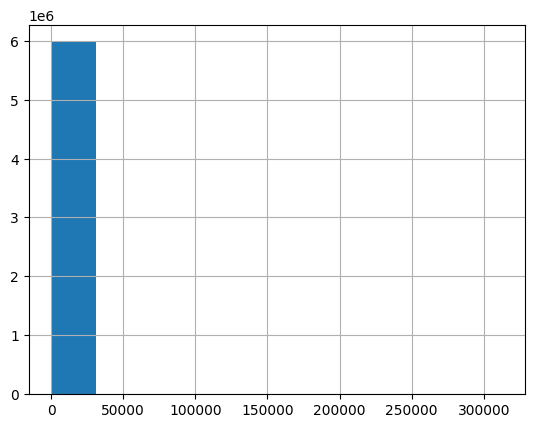

In [11]:
train_df['trip_distance'].hist()

In [12]:
train_df['trip_distance'].quantile(1)

np.float64(312722.3)

In [13]:
from src.features.feature_pipeline import FeatureEngineer
numerical = ["trip_distance"]
categorical = ["PU_DO"]
target = "duration"

preprocessor = FeatureEngineer()
# Use Polars for scalability becasue each month has like 2.5 - 3 Million records!

# Train and test df assumed to be loaded
X_train, y_train = preprocessor.fit_transform(train_df)
X_test, y_test = preprocessor.transform(test_df)

INFO:src.features.feature_pipeline:Fitting and transforming training data...
INFO:src.features.feature_pipeline:Dropping rows with missing airport fee...
INFO:src.features.feature_pipeline:Converting pickup and dropoff datetime columns...
INFO:src.features.feature_pipeline:Calculating trip duration in minutes...
INFO:src.features.feature_pipeline:Filtering out trips with invalid durations...
INFO:src.features.feature_pipeline:Creating PU_DO categorical feature...
INFO:src.features.feature_pipeline:Sorting dataframe by pickup datetime...
INFO:src.features.feature_pipeline:Training data transformation complete.
INFO:src.features.feature_pipeline:Transforming new data...
INFO:src.features.feature_pipeline:Dropping rows with missing airport fee...
INFO:src.features.feature_pipeline:Converting pickup and dropoff datetime columns...
INFO:src.features.feature_pipeline:Calculating trip duration in minutes...
INFO:src.features.feature_pipeline:Filtering out trips with invalid durations...
INFO:

In [39]:
type(X_train)

scipy.sparse._csr.csr_matrix

In [40]:
type(y_train)

numpy.ndarray

In [14]:
X_train.shape, X_test.shape

((5633435, 29248), (3146858, 29248))

In [ ]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2025/04/25 21:52:47 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:d:/Github Repos/Taxi-Duration-Prediction/mlruns/1', creation_time=1745607167422, experiment_id='1', last_update_time=1745607167422, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [36]:
import mlflow.catboost
import mlflow.lightgbm
import mlflow.xgboost


mlflow.autolog(log_datasets=False)
mlflow.xgboost.autolog(log_datasets=False)
mlflow.lightgbm.autolog(log_datasets=False)

with mlflow.start_run():

    mlflow.set_tag("Machine Learning Engineer", "Ahmad Hammad")

2025/04/25 22:05:37 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [32]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [33]:
lr_model = LinearRegression()
xgb_model = XGBRegressor()
catboost_model = CatBoostRegressor(iterations=300, verbose=0, allow_writing_files=False)
lgbm_model = LGBMRegressor()

In [34]:
lr_model.fit(X_train, y_train)
preds = lr_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

2025/04/25 22:03:56 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '46385f2914ce4bd3b91dd8d13d0bfcd6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow


2025/04/25 22:04:16 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


(22.261348506810982, 0.7249909895528694)

In [37]:
with mlflow.start_run() as run_rf:
        
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)

    # Make predictions and evaluate RandomForest
    predictions_rf = lr_model.predict(X_test)
    train_predictions = lr_model.predict(X_train)

    log_regression_metrics_run(y_true=y_train, predictions=train_predictions, prefix="train", n_features=X_train.shape[1])    
    log_regression_metrics_run(y_true=y_test, predictions=predictions_rf, prefix="test", n_features=X_train.shape[1])    

    mlflow.sklearn.log_model(artifact_path="lr_model", sk_model=lr_model, registered_model_name="LinearRegression")

2025/04/25 22:07:34 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/25 22:07:38 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/25 22:07:38 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'LinearRegression'.
Created version '1' of model 'LinearRegression'.


In [38]:
with mlflow.start_run() as run_rf:
        
    xgb_model = XGBRegressor()
    xgb_model.fit(X_train, y_train)

    # Make predictions and evaluate RandomForest
    predictions_rf = xgb_model.predict(X_test)
    train_predictions = xgb_model.predict(X_train)

    log_regression_metrics_run(y_true=y_train, predictions=train_predictions, prefix="train", n_features=X_train.shape[1])    
    log_regression_metrics_run(y_true=y_test, predictions=predictions_rf, prefix="test", n_features=X_train.shape[1])    

    mlflow.sklearn.log_model(artifact_path="xgb_model", sk_model=xgb_model, registered_model_name="XGBoost")
    

2025/04/25 22:09:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "d:\Github Repos\Taxi-Duration-Prediction\.venv\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [22:09:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/04/25 22:09:33 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/25 22:09:42 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/04/25 22:09:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered mo

In [ ]:
xgb_model.fit(X_train, y_train)
preds = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

In [30]:
lgbm_model.fit(X_train, y_train)
preds = lgbm_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

2025/04/25 21:58:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f6fcf4cbfbb142a3a254d5f91ec4b91c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current lightgbm workflow


2025/04/25 21:58:59 WARNING mlflow.lightgbm: Failed to log dataset information to MLflow Tracking. Reason: Unable to allocate 1.20 TiB for an array with shape (5633435, 29248) and data type float64


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17765
[LightGBM] [Info] Number of data points in the train set: 5633435, number of used features: 8756
[LightGBM] [Info] Start training from score 14.844049


KeyboardInterrupt: 

In [ ]:
catboost_model.fit(X_train, y_train)
preds = catboost_model.predict(X_test)
rmse = mean_squared_error(y_test, preds) ** 1 / 2
r2 = r2_score(y_test, preds)
rmse, r2

(23.295308613214505, 0.7122178035252196)